In [23]:
# подготовка к домашке урока 6:))
import pandahouse as ph # библиотека для работы с SQL в питоне
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
connection_default = {'host':'https://clickhouse.lab.karpov.courses', # подключаемся к аккаунту обычному
                     'database':'default',
                     'user':'student',
                     'password':'dpo_python_2020'}

connection_test = dict(host = 'https://clickhouse.lab.karpov.courses', # подключаемся к аккаунту с правами на редактирование с создание таблиц
                       database = 'test',
                       user = 'student-rw',
                       password = '656e2b0c9c')

In [7]:
# смотрим количество строк в таблице -- 6.2
q_check_read = '''
    SELECT count()
    FROM {db}.ldn_listings
    '''
q_check = ph.read_clickhouse(query = q_check_read, connection = connection_default)
q_check

,count()
0,85207


In [19]:
# выгружаем из таблицы данные о цене в зависимости от типа жилья -- 6.3
q_price_of_room_type_read = '''
    SELECT 
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price, -- грёбанные кавычки в паттерне!:(
        room_type
    FROM {db}.ldn_listings
    ORDER BY id ASC
    LIMIT 1000
    '''
q_price_of_room_type = ph.read_clickhouse(query = q_price_of_room_type_read, connection = connection_default)
# считаем 75-й перцентиль для каждого типа комнат и выводим 
q_75 = q_price_of_room_type \
    .groupby(by=['room_type'], as_index=False) \
    .quantile(q = 0.75)
q_75

,room_type,price
0,Entire home/apt,160.00
1,Hotel room,157.00
2,Private room,70.00
3,Shared room,69.25


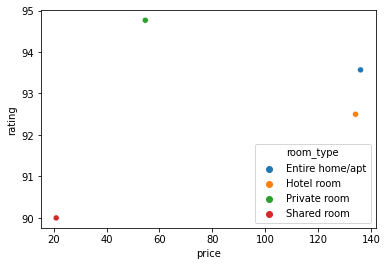

In [29]:
# строим график рассеивания, показывающий зависимость средней оценки от средней цены по типу жилья -- 6.4
q_plus_rating_read = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS rating
    FROM {db}.ldn_listings
    WHERE review_scores_rating != ''
    LIMIT 1000
    '''
q_plus_rating = ph.read_clickhouse(query = q_plus_rating_read, connection = connection_default)
# группируем по типу жилья и считаем среднее для цены и рейтинга
q_means = q_plus_rating.groupby(by=['room_type'], as_index=False)[['price','rating']].agg('mean')
sns.scatterplot(data=q_means, x="price", y="rating", hue="room_type")

In [72]:
# Проверяем, какие способы подтверждения аккаунта использовали хозяева, предлагающие "впечатления" -- 6.5
q_experience_read = '''
    SELECT 
        DISTINCT host_id,
        host_verifications
    FROM {db}.ldn_listings
    WHERE experiences_offered != 'none'
    '''
q_experience = ph.read_clickhouse(query = q_experience_read, connection = connection_default)
# Считаем, сколько раз встречался каждый способ верификации

# Обрабатываем столбец -- заменяем строковое представление списка на список строк 
q_experience['host_verifications'] = q_experience['host_verifications'] \
    .apply(lambda x: x.strip('"[] ')) \
    .apply(lambda c: c.replace("'", "")) \
    .apply(lambda y: y.split(', '))

# если применять explode к столбцу - подучается какая-то дичь:( Поэтому отдельной командой
q_experience_values = q_experience \
    .explode('host_verifications') \
    ['host_verifications'].value_counts()
q_experience_values

phone                    1361
email                    1345
reviews                  1309
government_id            1196
jumio                    1115
offline_government_id     469
work_email                279
facebook                  270
selfie                    252
identity_manual           227
manual_offline             70
google                     34
kba                        27
manual_online              16
sent_id                     6
Name: host_verifications, dtype: int64

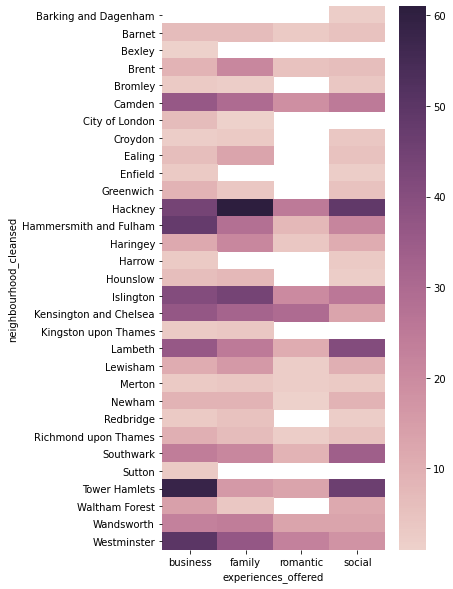

In [74]:
# Смотрим, для какого количества объявлений из разных районов хозяева указали впечатления разных типов -- 6.6
q_what_and_where_exp_read = '''
    SELECT 
        neighbourhood_cleansed,
        experiences_offered,
        count() AS experiences_count
    FROM {db}.ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
    '''
q_what_and_where_exp = ph.read_clickhouse(query = q_what_and_where_exp_read, connection = connection_default)
# Преобразовываем таблицу для более удобной визуализации

q_what_and_where_exp = q_what_and_where_exp \
    .pivot(index = 'neighbourhood_cleansed', columns = 'experiences_offered', values = 'experiences_count')

# Рисуем тепловую карту в оттенках фиолетового:)
plt.figure(figsize=(5, 10)) # Редактируем размер графика, чтобы всёбыло видно:) Первое - ширина, второе - высота.
sns.heatmap(q_what_and_where_exp, cmap=sns.cubehelix_palette(as_cmap=True))

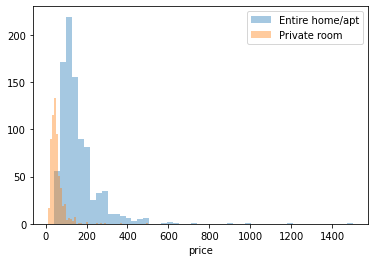

In [48]:
# Смотрим распределение цен за ночь для каждого типа жилья -- 6.7
q_price_by_room_type_read = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM {db}.ldn_listings
    WHERE experiences_offered != 'none'
    '''
q_price_by_room_type = ph.read_clickhouse(query = q_price_by_room_type_read, connection = connection_default)

# Строим график исходного распределения цен

sns.distplot(q_price_by_room_type.query("room_type=='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(q_price_by_room_type.query("room_type=='Private room'").price, kde=False, label='Private room')
plt.legend() # Без применения plt не подписывает, какой цвет к чему относится, хоть label-ы и проставлены
plt.show()

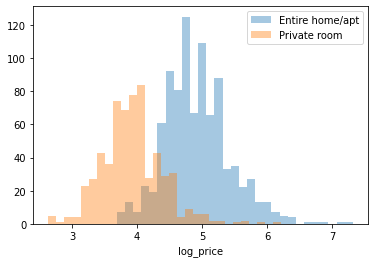

In [46]:
# И график логарифмических значений (всё ещё 6.7)

q_price_by_room_type['log_price'] = np.log(q_price_by_room_type.price)

sns.distplot(q_price_by_room_type.query("room_type=='Entire home/apt'").log_price, kde=False, label='Entire home/apt')
sns.distplot(q_price_by_room_type.query("room_type=='Private room'").log_price, kde=False, label='Private room')
plt.legend() 
plt.show()


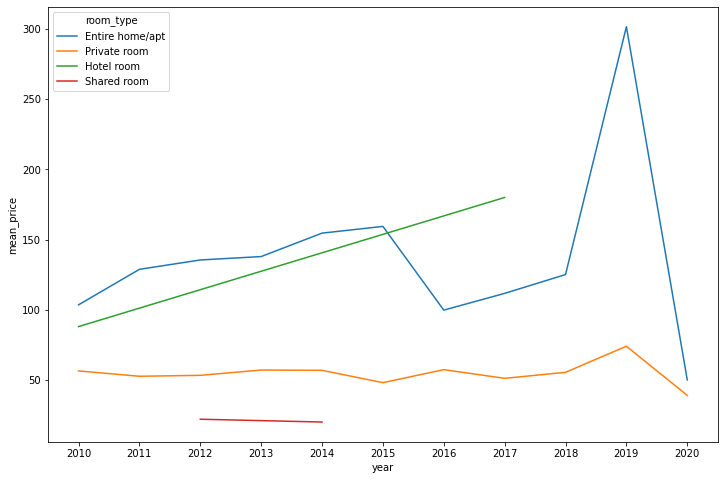

In [75]:
# Смотрим изменение средних цен на жильё для разных типов комнат по годам -- 6.8
q_annual_price_change_read = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        first_review
    FROM {db}.ldn_listings
    WHERE first_review > '2010-01-01'
    LIMIT 1000
    '''
q_annual_price_change = ph.read_clickhouse(query = q_annual_price_change_read, connection = connection_default)

# Приводим цену к среднему по году и типу жилья, а из даты оставляем только год
q_annual_price_change['first_review'] = q_annual_price_change['first_review'] \
    .apply(lambda x: x.split('-')[0])

q_annual_price_change = q_annual_price_change \
    .rename(columns={'first_review':'year'}) \
    .groupby(['room_type','year'], as_index = False) \
    .agg({'price': 'mean'}) \
    .rename(columns={'price':'mean_price'}) \
    .sort_values('year', ascending = True)

# Строим график динамики средних цен на жильё в зависимости от его типа по годам
plt.figure(figsize=(12, 8))
sns.lineplot(data=q_annual_price_change, x='year', y='mean_price', hue='room_type') 
# hue позволяет отрисовать несколько линий на одном графике разными цветами